In [1]:
!nvidia-smi

Thu Apr 28 11:49:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:17:00.0 Off |                  Off |
| 30%   55C    P2    62W / 230W |   1801MiB / 24256MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:65:00.0 Off |                  Off |
| 31%   

In [2]:
# check torch setup
import torch
torch.cuda.is_available()

True

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import matplotlib.pyplot as plt
from lensless.io import load_psf
from lensless.plot import plot_image, pixel_histogram
import numpy as np

# Visualize PSFs

In [3]:
downsample = 1
bg_pix = None      # turn off removing background pixel, which is estimated from top-left corner
nbits = 12         # RPi camera is 12 bits

dimensions : (3040, 4056, 3)
data type : uint16
max  : 4095
min  : 0
mean : 1.9224569567718606


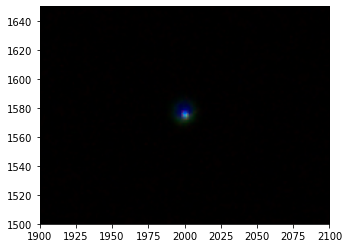

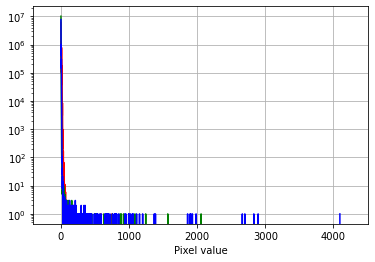

In [4]:
fp = "../psfs/lens.png"
gamma = 2.2
single_psf = False     # use same PSF per channel

psf = load_psf(fp=fp, verbose=True, downsample=downsample, single_psf=single_psf, return_float=False, bg_pix=bg_pix)
ax = plot_image(psf, gamma=gamma, normalize=True)
ax.set_xlim([1900, 2100]);
ax.set_ylim([1500, 1650]);
pixel_histogram(psf, nbits=nbits);

dimensions : (3040, 4056, 3)
data type : uint16
max  : 4094
min  : 0
mean : 84.57678515043773


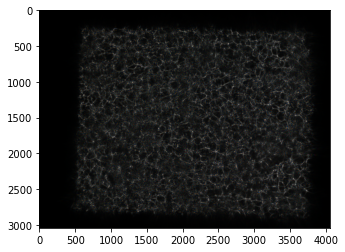

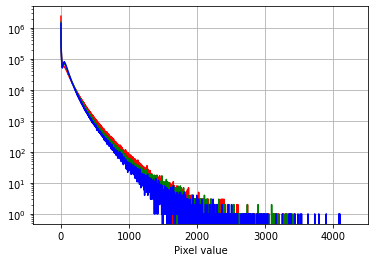

In [5]:
fp = "../psfs/tape.png"
gamma = 2.2
single_psf = False     # use same PSF per channel

psf = load_psf(fp=fp, verbose=True, downsample=downsample, single_psf=single_psf, return_float=False, bg_pix=bg_pix)
plot_image(psf, gamma=gamma, normalize=True)
pixel_histogram(psf, nbits=nbits);

dimensions : (3040, 4056, 3)
data type : uint16
max  : 4095
min  : 0
mean : 6.764968348818298


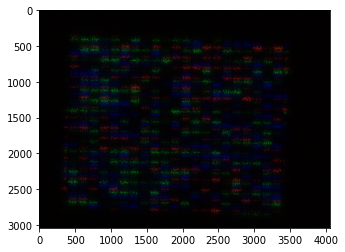

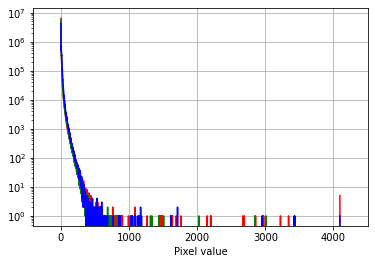

In [6]:
fp = "../psfs/adafruit.png"
gamma = 4
single_psf = False     # use same PSF per channel

psf = load_psf(fp=fp, verbose=True, downsample=downsample, single_psf=single_psf, return_float=False, bg_pix=bg_pix)
plot_image(psf, gamma=gamma, normalize=True)
pixel_histogram(psf, nbits=nbits);

dimensions : (760, 1014, 3)
data type : uint16
max  : 500
min  : 0
mean : 8.385676407488148


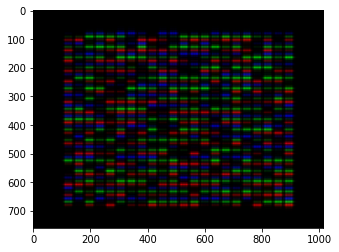

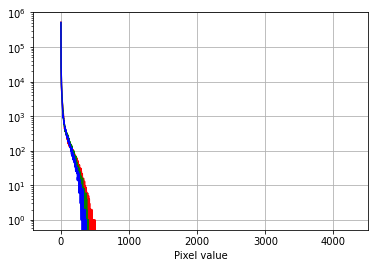

In [9]:
# fp = "../psfs/simulated_adafruit.png"
fp = "../psfs/simulated_adafruit_crop0.8_down4_11042022_10h01.png"
gamma = 2.2
single_psf = False     # use same PSF per channel

psf = load_psf(fp=fp, verbose=True, downsample=downsample, single_psf=single_psf, return_float=False, bg_pix=bg_pix)
plot_image(psf, gamma=gamma, normalize=True)
pixel_histogram(psf, nbits=nbits);

dimensions : (3040, 4056, 3)
data type : uint16
max  : 750
min  : 0
mean : 1.5163894890394132


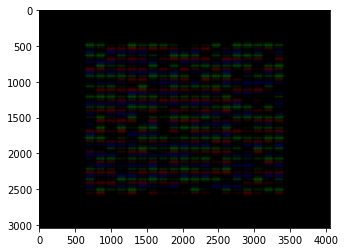

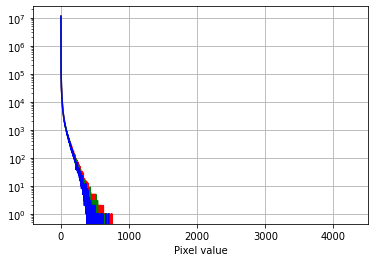

In [8]:
fp = "../psfs/simulated_adafruit_noise.png"
gamma = 4
single_psf = False     # use same PSF per channel

psf = load_psf(fp=fp, verbose=True, downsample=downsample, single_psf=single_psf, return_float=False, bg_pix=bg_pix)
plot_image(psf, gamma=gamma, normalize=True)
pixel_histogram(psf, nbits=nbits);

# Visualizing learned SLM pattern

In [3]:
from lenslessclass.models import SLMMultiClassLogistic
from lenslessclass.datasets import MNISTAugmented
import torch.nn as nn
from waveprop.devices import SLMOptions, SensorOptions, slm_dict, sensor_dict, SensorParam
from lensless.plot import plot_image, pixel_histogram

path = "../MNIST_no_psf_down8_logistic_reg_adam_relu_0p8crop_batch200_100epoch.pth"
path = "../April11_MNIST_no_psf_down8_logistic_reg_clamp.pth"

# model parameters, SHOULD SAVE THIS!
device = "cpu"
crop_fact = 0.8
deadspace = True
scene2mask = 0.4
mask2sensor = 0.004
sensor_act = nn.ReLU()
down_out = 128
sensor = SensorOptions.RPI_HQ.value
slm = SLMOptions.ADAFRUIT.value
augmented_dataset = "../data/MNIST_no_psf_down8"

# need this for loading correctly since we train with DataParallel!! 
# -- https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686
# -- or could use this solution: https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/4
multi_gpu = True      

# derived param
train_set = MNISTAugmented(path=augmented_dataset, train=True)
input_shape = train_set.output_dim
sensor_param = sensor_dict[sensor]
if down_out:
    output_dim = tuple((sensor_param[SensorParam.SHAPE] * 1 / down_out).astype(int))


model = SLMMultiClassLogistic(
    input_shape=input_shape,
    slm_config=slm_dict[slm],
    sensor_config=sensor_param,
    crop_fact=crop_fact,
    device=device,
    deadspace=deadspace,
    scene2mask=scene2mask,
    mask2sensor=mask2sensor,
    device_mask_creation="cpu",  # TODO: bc doesn't fit on GPU
    output_dim=output_dim,
    sensor_activation=sensor_act,
    multi_gpu=multi_gpu
)
model.load_state_dict(torch.load(path))

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

NameError: name 'torch' is not defined

In [4]:
slm_weights = model.slm_vals.clone()
print("Minimum :", slm_weights.min())
print("Maximum :", slm_weights.max())
print("Shape :", slm_weights.shape)

Minimum : tensor(0., grad_fn=<MinBackward1>)
Maximum : tensor(1., grad_fn=<MaxBackward1>)
Shape : torch.Size([51, 22])


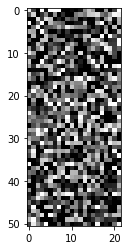

In [13]:
import matplotlib.pyplot as plt

plt.imshow(slm_weights.detach().numpy(), cmap="gray")

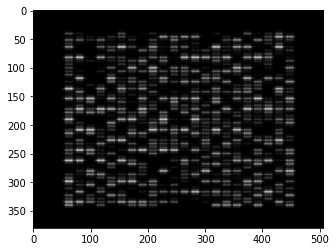

In [5]:
# -- plot corresponding PSF
model.compute_intensity_psf()
learned_psf = model._psf.cpu().detach().numpy().squeeze()
# learned_psf = model.psf(numpy=True)

gamma = 2.2
plot_image(learned_psf, gamma=gamma, normalize=True);

In [ ]:
## -- LOADING WITHOUT MULTIGPU: https://discuss.pytorch.org/t/solved-keyerror-unexpected-key-module-encoder-embedding-weight-in-state-dict/1686/4

# original saved file with DataParallel
state_dict = torch.load('myfile.pth.tar')
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
model.load_state_dict(new_state_dict)

# Measured data

dimensions : (480, 640, 3)
data type : uint8
max  : 108
min  : 0
mean : 1.3989811197916666


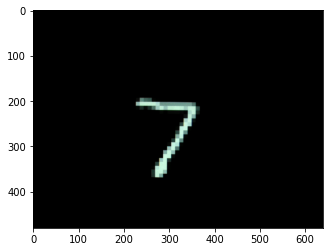

In [16]:
from lensless.io import load_image, plot_image


gamma = 1

lensed_fp = "/home/bezzam//MNIST_lensed/test/img0.png"

data = load_image(lensed_fp, verbose=True)
plot_image(data, gamma=gamma, normalize=True);

#### tape

Setup time : 0.1982123851776123 s
Processing time : 3.8373687267303467 s


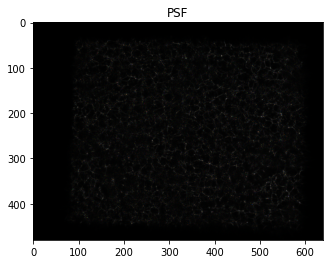

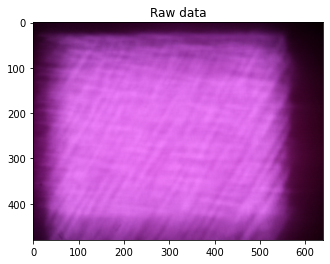

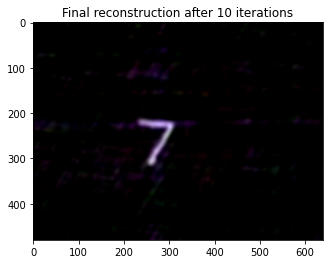

In [11]:
import time
from lensless.io import load_data
from lensless import ADMM

psf_fp = "/home/bezzam/LenslessPiCam/data/psf/tape_rgb.png"
data_fp = "/home/bezzam//MNIST_tape/test/img0.png"
n_iter = 10
disp = 20
gamma = 1


psf, data = load_data(
    psf_fp=psf_fp,
    data_fp=data_fp,
    shape=(480, 640),
    downsample=None,
    gamma=gamma
)

start_time = time.time()
recon = ADMM(psf)
recon.set_data(data)
print(f"Setup time : {time.time() - start_time} s")

start_time = time.time()
res = recon.apply(n_iter=n_iter, disp_iter=disp, gamma=gamma, plot=True)
print(f"Processing time : {time.time() - start_time} s")

# MNIST

In [5]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
mnist_original = datasets.MNIST(
    root='../data', train=False, download=True, transform=trans
)

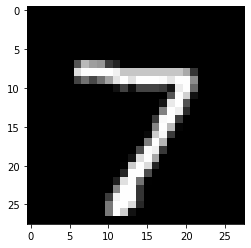

In [7]:
img, label = mnist_original[0] 
plot_image(img.numpy().squeeze(), gamma=gamma, normalize=True);

# Simulate (on the fly)

In [11]:
# determine output dimension to keep similar number of pixels as 
# original MNIST and same aspect ratio
# 28 * 28 = 784
# h * w = 784    s.t. w/h = 3040/4056
# -> w * (4056/3040*w) = 784
# -> w = sqrt(768  * 3040 / 4056)

import numpy as np

down_fact = 16

w = int(np.sqrt(784 / down_fact * 3040 / 4056))
h = int(4056/3040*w)
output_dim_mnist = (w, h)
print(output_dim_mnist)
print(w * h)

(6, 8)
48


In [13]:
down_orig = 16
target_dim = np.array([28, 28])
w = int(np.round(np.sqrt(np.prod(target_dim) / down_orig)))
print(w, w)
print(w * w)

7 7
49


In [6]:
down_orig = 2
target_dim = np.array([28, 28])

w = np.sqrt(np.prod(target_dim) / down_fact * 3040 / 4056)
h = 4056/3040*w
w = int(np.round(w))
h = int(np.round(h))
output_dim_mnist = (w, h)
print(output_dim_mnist)
print(w * h)

(17, 23)
391


### lens

(100, 100)
(24, 32)


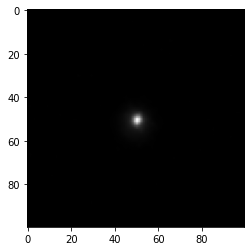

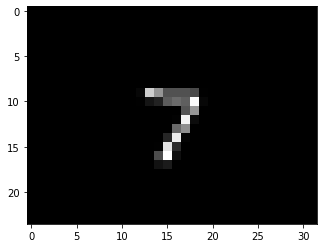

In [7]:
from lenslessclass.datasets import MNISTPropagated
import numpy as np
from lensless.plot import plot_image

dataset_idx = 0
psf_fp = "../psfs/lens.png"
noise_type = "speckle"
# noise_type = None
snr = 40
mask2sensor = 7.53e-3
crop_psf = 100
# output_dim = (480, 640)
output_dim = output_dim_mnist
down_psf = 1
object_height = 0.12
grayscale = True
single_psf = True
scene2mask = 40e-2
device = "cpu"


pixel_size = np.array([1.55e-6, 1.55e-6])
sensor_shape = np.array([3040, 4056])
sensor_size = pixel_size * sensor_shape

ds = MNISTPropagated(
    psf_fp=psf_fp,
    downsample_psf=down_psf,
    output_dim=output_dim,
    scene2mask=scene2mask,
    mask2sensor=mask2sensor,
    sensor_size=sensor_size,
    object_height=object_height,
    device=device,
    crop_psf=crop_psf,
    grayscale=grayscale,
    vflip=False,
    train=False,
    single_psf=single_psf,
    root="../data",
    noise_type=noise_type,
    snr=snr
)

# plot PSF
if grayscale:
    psf_data = ds.psf.cpu().clone().numpy().squeeze()
else:
    psf_data = ds.psf.cpu().clone().numpy().transpose(1, 2, 0)
print(psf_data.shape)
ax = plot_image(psf_data);
if not crop_psf:
    ax.set_xlim([1900, 2100]);
    ax.set_ylim([1500, 1650]);

# plot simulated
img, label = ds[dataset_idx]
if grayscale:
    img_data = img.cpu().clone().numpy().squeeze()
else:
    img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
plot_image(img_data);

#### tape

(3040, 4056)
(24, 32)


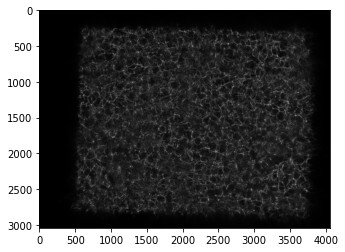

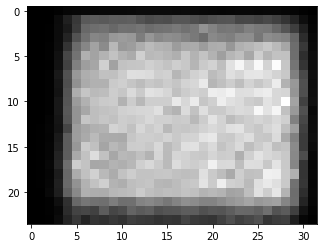

In [8]:
from lenslessclass.datasets import MNISTPropagated
import numpy as np
from lensless.plot import plot_image

dataset_idx = 0
psf_fp = "../psfs/tape.png"
# output_dim = (480, 640)
output_dim = (24, 32)
noise_type = "speckle"
snr = 40
crop_psf = False
down_psf = 1
object_height = 0.12
grayscale = True
single_psf = False
scene2mask = 40e-2
mask2sensor = 4e-3
device = "cpu"


pixel_size = np.array([1.55e-6, 1.55e-6])
sensor_shape = np.array([3040, 4056])
sensor_size = pixel_size * sensor_shape

ds = MNISTPropagated(
    psf_fp=psf_fp,
    downsample_psf=down_psf,
    output_dim=output_dim,
    scene2mask=scene2mask,
    mask2sensor=mask2sensor,
    sensor_size=sensor_size,
    object_height=object_height,
    device=device,
    crop_psf=crop_psf,
    grayscale=grayscale,
    vflip=False,
    train=False,
    single_psf=single_psf,
    root="../data",
    noise_type=noise_type,
    snr=snr
)

# plot PSF
if grayscale:
    psf_data = ds.psf.cpu().clone().numpy().squeeze()
else:
    psf_data = ds.psf.cpu().clone().numpy().transpose(1, 2, 0)
print(psf_data.shape)
ax = plot_image(psf_data, gamma=2.2);

# plot simulated
img, label = ds[dataset_idx]
if grayscale:
    img_data = img.cpu().clone().numpy().squeeze()
else:
    img_data = img.cpu().clone().numpy().transpose(1, 2, 0)
print(img_data.shape)
plot_image(img_data);

# Simulated (from dataset)

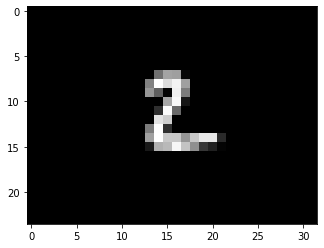

In [9]:
import torchvision.transforms as transforms
from lenslessclass.datasets import MNISTAugmented
import numpy as np

dataset = "../data/MNIST_lens_down128_height0.12"
dataset = "../data/MNIST_lens_outdim768_height0.12_croppsf100"
idx = 1
gamma = 2.2

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
ds = MNISTAugmented(path=dataset, train=False, transform=trans)
input_image, label = ds[idx]
input_image_cpu = np.transpose(input_image.cpu(), (1, 2, 0))
plot_image(ds[idx][0].numpy().squeeze(), gamma=gamma, normalize=True);

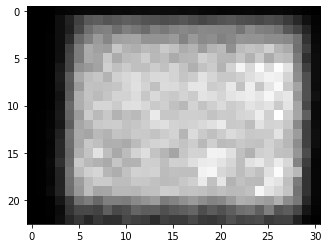

In [25]:
import torchvision.transforms as transforms
from lenslessclass.datasets import MNISTAugmented
import numpy as np

dataset = "../data/MNIST_tape_down128_height0.12"
idx = 0

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
ds = MNISTAugmented(path=dataset, train=False, transform=trans)
input_image, label = ds[idx]
input_image_cpu = np.transpose(input_image.cpu(), (1, 2, 0))
plot_image(ds[idx][0].numpy().squeeze(), gamma=gamma, normalize=True);